In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import chi2
import itertools

%matplotlib inline

## ARMA Model

***ARMA model stands for Auto-Regressive Moving Average model.***

$$X(t) = C + (\delta_1 \cdot X(t - 1) + \delta_2 \cdot X(t - 2) + ...) + (\theta_1 \cdot Er(t - 1) + 
                                                                          \theta_2 \cdot Er(t - 2) + ...) + Er(t)$$
                                                                          
***ARMA model is a combination of AR model and the MA model. It makes use of the previous values and the residuals(errors) associated with the previous values to predict the current value.***

In [54]:
actual_data = pd.read_csv("../../datasets/stock_prices/index_2018.csv")
df = actual_data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [55]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df_index = df["date"]
df.drop("date", axis=1, inplace=True)
df.index = df_index
df.index.name = None

df = df.asfreq("b")

df.apply(lambda x: x.fillna(method="ffill"))

df_spx = pd.DataFrame(df["spx"])
df_ftse = pd.DataFrame(df["ftse"])

df_ftse["returns"] = df_ftse["ftse"].pct_change(1)

In [56]:
def LLR_test(model1, model2, df=1):
    """
        model1 -> First model
        model2 -> Second model
        df -> Degrees of freedom(default 1 as we are generally comparing models of only one order difference)
    """
    L1 = model1.fit().llf
    L2 = model2.fit().llf
    LR = 2 * (L2 - L1)
    p = chi2.sf(LR, df).round(4)
    return p

## ARMA(P, Q)

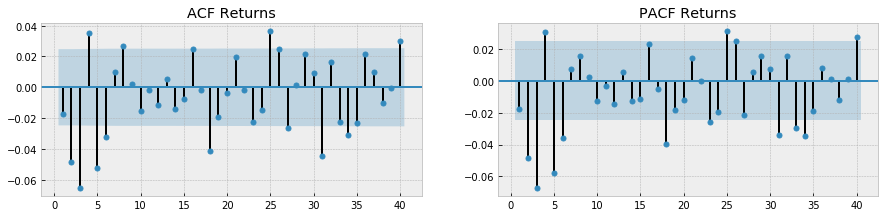

In [57]:
with plt.style.context("bmh"):
    layout = (2, 2)
    plt.figure(figsize=(15, 7))
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sgt.plot_acf(df_ftse["returns"][1:], lags=40, zero=False, unbiased=True, ax=acf_ax, title="ACF Returns")
    sgt.plot_pacf(df_ftse["returns"][1:], lags=40, zero=False, method="ols", ax=pacf_ax, title="PACF Returns")
    plt.grid(True)
    plt.show()

***MA order(Q) -> 8, AR order(P) -> 6***

In [146]:
def ARMA_test(data, ar_order, ma_order):
    count = 0
    for ar_i in range(1, ar_order+1):
        for ma_i in [ar_i-1, ar_i, ar_i+1]:
            model = ARMA(data, order=(ar_i, ma_i))
            try:
                result = model.fit()
                print("ARMA({}, {}) --> LLF: {:.2f}, p-value: {:.5f}, IC(AIC, BIC, HQIC): ({:.2f}, {:.2f}, {:.2f})".format(ar_i, 
                                                                                                   ma_i, result.llf, 
                                                                                                   result.pvalues[-1], 
                                                                                                   result.aic, 
                                                                                                   result.bic, 
                                                                                                   result.hqic))
                if ar_i > 1 and ma_i > 1:
                    llr_test_p_values = LLR_test(ARMA(data, order=(ar_i-1, ma_i-1)), ARMA(data, 
                                                                                     order=(ar_i, ma_i)),
                                                 df=(ar_i+ma_i)-(ar_i+ma_i-2))
                    print("LLR Test for ARMA({}, {}) and ARMA({}, {}) p-value: {}".format(ar_i-1, ma_i-1, ar_i, ma_i,
                                                                                          llr_test_p_values))
                    if llr_test_p_values > 0.05:
                        print("ARMA({}, {}) insignificant, exiting.".format(ar_i, ma_i))
                print("-----------------------------------------------------------------------------------------------")
            except ValueError:
                count += 1
                if count <= 5:
                    print("Skipping ARMA({}, {}), can't compute coefficients due to non-stationarity.".format(ar_i,
                                                                                                              ma_i))
                    print("-----------------------------------------------------------------------------------------------")
                else:
                    print("Exiting, can't compute ARMA({}, {}) coefficients due to non-stationarity.".format(ar_i,
                                                                                                              ma_i))
                    print("-----------------------------------------------------------------------------------------------")
                    return

In [147]:
ARMA_test(df_ftse["returns"][1:], 8, 6)

ARMA(1, 0) --> LLF: 19304.34, p-value: 0.16324, IC(AIC, BIC, HQIC): (-38602.69, -38582.45, -38595.68)
-----------------------------------------------------------------------------------------------
ARMA(1, 1) --> LLF: 19319.71, p-value: 0.00000, IC(AIC, BIC, HQIC): (-38631.42, -38604.44, -38622.07)
-----------------------------------------------------------------------------------------------
ARMA(1, 2) --> LLF: 19322.74, p-value: 0.00762, IC(AIC, BIC, HQIC): (-38635.47, -38601.75, -38623.79)
-----------------------------------------------------------------------------------------------
ARMA(2, 1) --> LLF: 19322.87, p-value: 0.00000, IC(AIC, BIC, HQIC): (-38635.74, -38602.02, -38624.06)
-----------------------------------------------------------------------------------------------
ARMA(2, 2) --> LLF: 19322.97, p-value: 0.66895, IC(AIC, BIC, HQIC): (-38633.94, -38593.47, -38619.92)
LLR Test for ARMA(1, 1) and ARMA(2, 2) p-value: 0.0383
---------------------------------------------------

## Residuals

In [153]:
df_ftse["residuals"] = ARMA(df_ftse["returns"][1:], order=(5, 4)).fit().resid

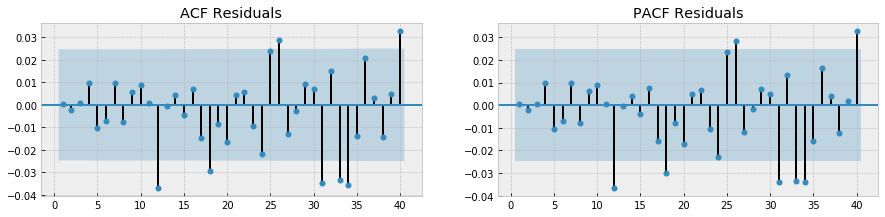

In [157]:
with plt.style.context("bmh"):
    layout = (2, 2)
    plt.figure(figsize=(15, 7))
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sgt.plot_acf(df_ftse["residuals"][1:], lags=40, zero=False, unbiased=True, ax=acf_ax, title="ACF Residuals")
    sgt.plot_pacf(df_ftse["residuals"][1:], lags=40, zero=False, method="ols", ax=pacf_ax, title="PACF Residuals")
    plt.grid(True)
    plt.show()

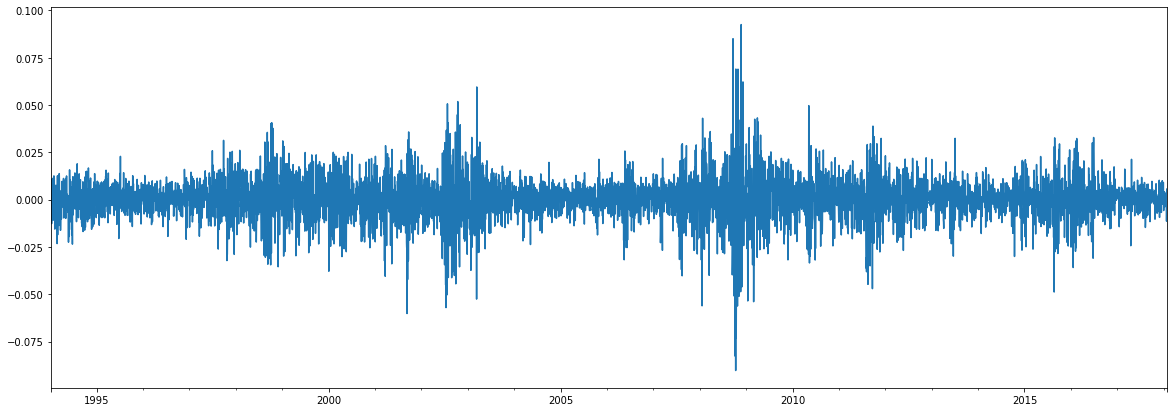

In [160]:
plt.figure(figsize=(20, 7))
df_ftse["residuals"].plot()

***Seems to be white noise(stationary), which is what we want.***